# MLNS ASSIGNEMENT - MISSING LINK PREDICTION

## I - INITIALISING ENVIRONMENT

In [1]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [15]:
node_info = pd.read_csv("../data/node_information.csv", header=None, index_col=0)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])

In [16]:
print(node_info.shape)
node_info.head(-5)

(3597, 932)


,1,2,3,4,5,6,7,8,9,10,...,923,924,925,926,927,928,929,930,931,932
0,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
train_set

,source,target,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1
...,...,...,...
10491,81,6464,0
10492,4,6433,0
10493,3341,6717,1
10494,1562,4656,0


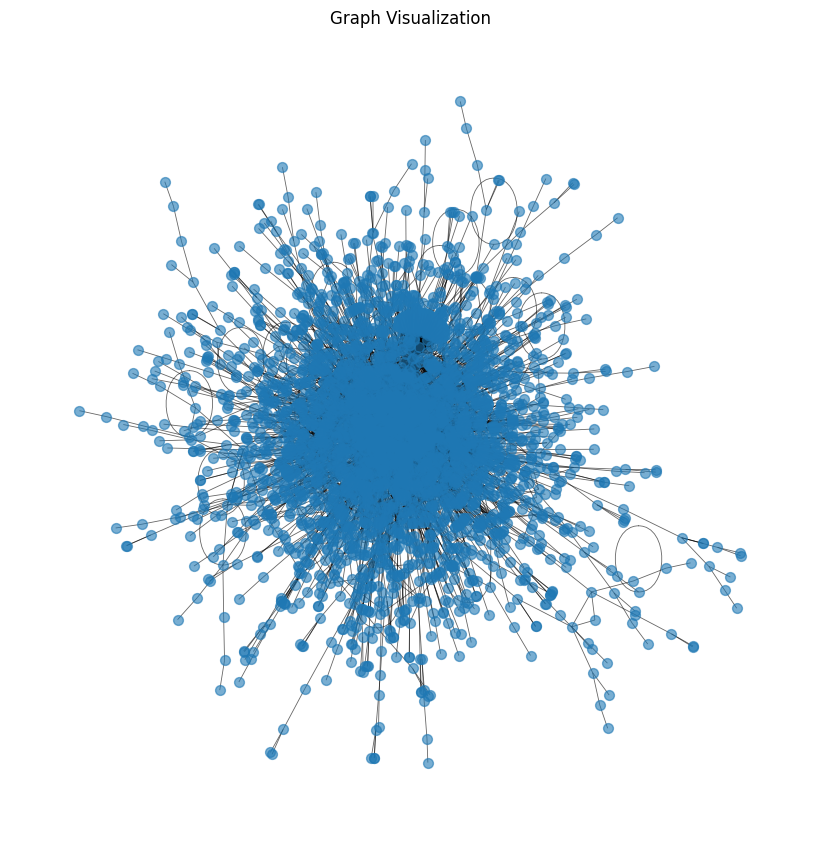

In [18]:
edges = train_set[train_set['label'] == 1][['source', 'target']].values.tolist()

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=False, node_size = 50, alpha = 0.6, width = 0.6)
plt.title("Graph Visualization")
plt.show()

Number of nodes: 3597
Number of edges: 5248


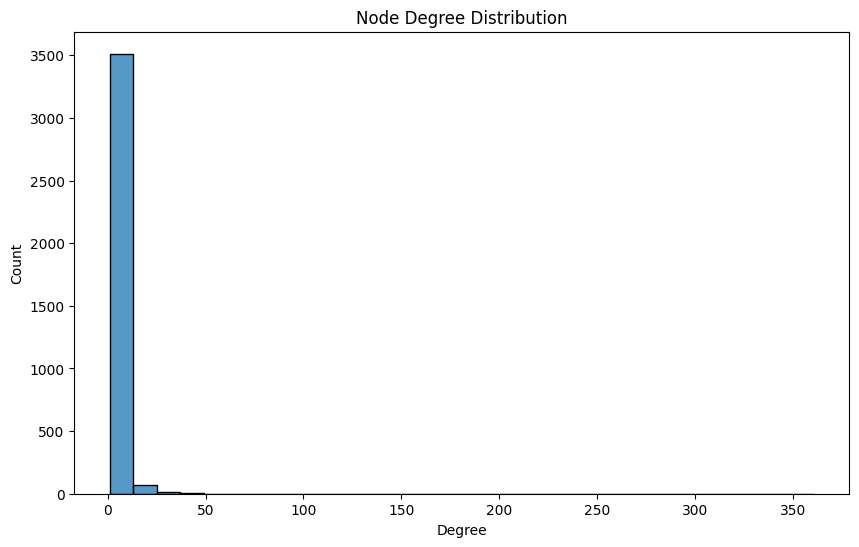

label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [19]:
# Graph Information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Node Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
sns.histplot(degrees, kde=False, bins=30)
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

# Label distribution
print(train_set['label'].value_counts(normalize=True))

## II - Feature Engineering

In [20]:
# Cosine Similarity
def calculate_cosine_similarity(node_encodings, source_node, target_node):
    source_vector = node_encodings.loc[source_node].values.reshape(1, -1)
    target_vector = node_encodings.loc[target_node].values.reshape(1, -1)
    return cosine_similarity(source_vector, target_vector)[0][0]

train_set['cosine_similarity'] = train_set.apply(lambda row: calculate_cosine_similarity(node_info, row['source'], row['target']), axis=1)

In [21]:
def common_neighbors(G, u, v):
        return len(list(nx.common_neighbors(G, u, v)))

train_set['common_neighbors'] = train_set.apply(lambda row: common_neighbors(G, row['source'], row['target']), axis=1)
train_set.head()

,source,target,label,cosine_similarity,common_neighbors
0,939,3809,1,0.000000,0
1,2442,5784,1,0.308607,1
2,179,3809,1,0.000000,2
3,857,2280,1,0.000000,0
4,1358,5722,1,0.288675,0


## III - Data Modelling

### a) Random Baseline

In [15]:
###################
# random baseline #
###################

# Load test samples 
with open("test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]

# Make random predictions
random_predictions = np.random.choice([0, 1], size=len(test_set))
random_pred = zip(np.array(range(len(test_set))), random_predictions)

# note: Kaggle requires that you add "ID" and "category" column headers

with open("random_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in random_pred:
         csv_out.writerow(row)
    pred.close()

### b) Graph Neural Network